# Soft Actor Critic

#### Off Policy 

## Environment

In [22]:
import gymnasium as gym

import matplotlib
import matplotlib.pyplot as plt

**Continuous Actions:**  Use a `Box(-1, +1, (2,), dtype=np.float32): (np.array([main, lateral]))` action space with two components: 

1. **Main Engine Throttle (`main`):**  
   1. - **Off:**  If `main < 0`.
   2. - **Throttle Scaling:**  Increases linearly from 50% to 100% as `main` ranges from 0 to 1.
   - **Note:**  The main engine does not operate below 50% power.
 
2. **Lateral Boosters Throttle (`lateral`):**
   1. - **Inactive:**  If `-0.5 < lateral < 0.5`.
   2. - **Left Booster:**  Activates when `lateral < -0.5`, scaling throttle from 50% to 100% as `lateral` decreases from -0.5 to -1.
   3. - **Right Booster:**  Activates when `lateral > 0.5`, scaling throttle from 50% to 100% as `lateral` increases from 0.5 to 1.

In [23]:
# Select Lunar Lander v3 as environment
env = gym.make("LunarLander-v3", continuous=True, render_mode="rgb_array")

# Get the number of state observations
state, info = env.reset()
n_observations = len(state)
print(f"Number of state observations: {n_observations}")

print("""State (Observation Space):
x, y
vel_x, vel_y
angle, angle_vel
left_leg_touching, right_leg_touching
      """)
print("Current state: ", state)

print("""Units of the state are as follows:
      ‘x’: (units), ‘y’: (units), 
      ‘vx’: (units/second), ‘vy’: (units/second), 
      ‘angle’: (radians), ‘angular velocity’: (radians/second)
      """)

Number of state observations: 8
State (Observation Space):
x, y
vel_x, vel_y
angle, angle_vel
left_leg_touching, right_leg_touching
      
Current state:  [-0.0076169   1.418684   -0.77152574  0.34502536  0.00883288  0.17476211
  0.          0.        ]
Units of the state are as follows:
      ‘x’: (units), ‘y’: (units), 
      ‘vx’: (units/second), ‘vy’: (units/second), 
      ‘angle’: (radians), ‘angular velocity’: (radians/second)
      


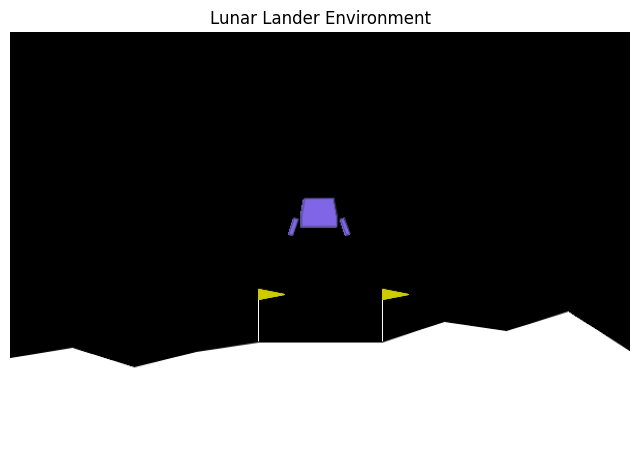

In [24]:
# Reset the environment to get the initial state
state, info = env.reset()

for i in range(40):
    env.step(action=[0, 0])
# Render the environment to get an RGB image
frame = env.render()

# Plot the image
plt.figure(figsize=(8, 6))
plt.imshow(frame)
plt.axis("off")
plt.title("Lunar Lander Environment")
plt.show()

## Plotting Helper

In [25]:
# set up matplotlib
is_ipython = "inline" in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()


def plot_metrics(episode_durations, rewards, policy_losses, value_losses, show_result=False, save_path=None):
    # Create a figure with a 2x2 grid
    fig, axes = plt.subplots(2, 2, figsize=(12, 10), dpi=100)
    fig.suptitle("Training Metrics" if not show_result else "Results", fontsize=16)

    # Plot Episode Durations
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    axes[0, 0].set_title("Episode Durations")
    axes[0, 0].set_xlabel("Episode")
    axes[0, 0].set_ylabel("Duration")
    axes[0, 0].plot(durations_t.cpu().numpy(), label="Duration")

    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        axes[0, 0].plot(means.cpu().numpy(), label="100-Episode Avg", linestyle="--")
    axes[0, 0].legend()

    # Plot Rewards
    rewards_t = torch.tensor(rewards, dtype=torch.float)
    axes[0, 1].set_title("Rewards")
    axes[0, 1].set_xlabel("Episode")
    axes[0, 1].set_ylabel("Reward")
    axes[0, 1].plot(rewards_t.cpu().numpy(), label="Reward")

    if len(rewards_t) >= 100:
        reward_means = rewards_t.unfold(0, 100, 1).mean(1).view(-1)
        reward_means = torch.cat((torch.zeros(99), reward_means))
        axes[0, 1].plot(reward_means.cpu().numpy(), label="100-Episode Avg", linestyle="--")
    axes[0, 1].legend()

    # Plot Policy Loss
    policy_t = torch.tensor(policy_losses, dtype=torch.float)
    axes[1, 0].set_title("Policy Loss")
    axes[1, 0].set_xlabel("Episode")
    axes[1, 0].set_ylabel("Loss")
    axes[1, 0].plot(policy_t.cpu().numpy(), label="Policy Loss", color="orange")
    axes[1, 0].legend()

    # Plot Value Loss
    value_t = torch.tensor(value_losses, dtype=torch.float)
    axes[1, 1].set_title("Value Loss")
    axes[1, 1].set_xlabel("Episode")
    axes[1, 1].set_ylabel("Loss")
    axes[1, 1].plot(value_t.cpu().numpy(), label="Value Loss", color="green")
    axes[1, 1].legend()

    # Adjust layout and save/show
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Add space for the suptitle
    if save_path:
        plt.savefig(save_path + ".png", dpi=300)
        print(f"Metrics figure saved to {save_path}")

    if "get_ipython" in globals():
        if not show_result:
            display.clear_output(wait=True)
            display.display(fig)
        else:
            display.display(fig)
    else:
        plt.show()

    plt.close(fig)

## ReplayBuffer

In [26]:
import os

import torch
import torch.nn as nn
from typing import Tuple, Type
import numpy as np
import torch.optim as optim
from pathlib import Path
import torch
import json
from typing import Optional
from tqdm import tqdm
from datetime import datetime

In [27]:
from ReplayBuffer import ReplayBuffer
from models.SAC import ActorNetwork
from models.models import CriticNetwork, ValueNetwork
from models.utils import update_target_network

## Neural Networks

## Losses

In [28]:
class SACLosses:
    def __init__(self, alpha: float = 0.2, automatic_entropy: bool = True, target_entropy: float = -1.0):
        """
        Initializes the loss computation and entropy coefficient handling.

        Args:
            alpha (float): Initial entropy coefficient.
            automatic_entropy (bool): Whether to use automatic entropy adjustment.
            target_entropy (float): Target entropy value.
        """
        self.automatic_entropy = automatic_entropy
        if automatic_entropy:
            self.log_alpha = torch.tensor(
                [torch.log(torch.tensor(alpha))],
                requires_grad=True,
                device="cuda" if torch.cuda.is_available() else "cpu",
            )
            self.target_entropy = target_entropy
        else:
            self.alpha = alpha

    def get_alpha(self) -> torch.Tensor:
        """
        Returns the current entropy coefficient.

        Returns:
            torch.Tensor: Entropy coefficient.
        """
        return self.log_alpha.exp() if self.automatic_entropy else torch.tensor(self.alpha)

    def alpha_loss(self, log_prob: torch.Tensor) -> torch.Tensor:
        """
        Computes the loss for the entropy coefficient.

        Args:
            log_prob (torch.Tensor): Log probabilities of actions.

        Returns:
            torch.Tensor: Loss for adjusting the entropy coefficient.
        """
        if self.automatic_entropy:
            return -(self.log_alpha * (log_prob + self.target_entropy).detach()).mean()
        return torch.tensor(0.0, device=log_prob.device)


def compute_actor_loss(
    actor: Type[nn.Module],
    critic_1: Type[nn.Module],
    critic_2: Type[nn.Module],
    states: torch.Tensor,
    alpha: torch.Tensor,
) -> torch.Tensor:
    """
    Computes the actor loss using the reparameterization trick.

    Args:
        actor (ActorNetwork): The actor network.
        critic_1 (CriticNetwork): The first critic network.
        critic_2 (CriticNetwork): The second critic network.
        states (torch.Tensor): Batch of states.
        alpha (torch.Tensor): Entropy coefficient.

    Returns:
        torch.Tensor: Actor loss.
    """
    actions, log_probs = actor.sample_action(states)
    q1 = critic_1(states, actions)
    q2 = critic_2(states, actions)
    q_min = torch.min(q1, q2)
    return (alpha * log_probs - q_min).mean()


def compute_critic_loss(
    critic: Type[nn.Module],
    target_value_net: Type[nn.Module],
    states: torch.Tensor,
    actions: torch.Tensor,
    rewards: torch.Tensor,
    next_states: torch.Tensor,
    dones: torch.Tensor,
    gamma: float,
) -> torch.Tensor:
    """
    Computes the critic loss using the TD error.

    Args:
        critic (CriticNetwork): The critic network.
        target_value_net (ValueNetwork): The target value network.
        states (torch.Tensor): Batch of states.
        actions (torch.Tensor): Batch of actions.
        rewards (torch.Tensor): Batch of rewards.
        next_states (torch.Tensor): Batch of next states.
        dones (torch.Tensor): Batch of done flags.
        gamma (float): Discount factor.

    Returns:
        torch.Tensor: Critic loss.
    """
    with torch.no_grad():
        target_value = target_value_net(next_states)
        target_q = rewards + gamma * (1 - dones) * target_value
    predicted_q = critic(states, actions)
    return nn.MSELoss()(predicted_q, target_q)


def compute_value_loss(
    value_net: Type[nn.Module],
    critic_1: Type[nn.Module],
    critic_2: Type[nn.Module],
    states: torch.Tensor,
    alpha: torch.Tensor,
) -> torch.Tensor:
    """
    Computes the value loss using the Bellman equation.

    Args:
        value_net (ValueNetwork): The value network.
        critic_1 (CriticNetwork): The first critic network.
        critic_2 (CriticNetwork): The second critic network.
        states (torch.Tensor): Batch of states.
        alpha (torch.Tensor): Entropy coefficient.

    Returns:
        torch.Tensor: Value loss.
    """
    with torch.no_grad():
        actions, log_probs = actor.sample_action(states)
        q1 = critic_1(states, actions)
        q2 = critic_2(states, actions)
        q_min = torch.min(q1, q2)
        target_value = q_min - alpha * log_probs
    predicted_value = value_net(states)
    return nn.MSELoss()(predicted_value, target_value)

## Optimization and Target Network Update

In [29]:
def setup_optimizers(
    actor: Type[nn.Module],
    critic_1: Type[nn.Module],
    critic_2: Type[nn.Module],
    value_net: Type[nn.Module],
    learning_rate: float = 3e-4,
) -> Tuple[optim.Optimizer, optim.Optimizer, optim.Optimizer, optim.Optimizer]:
    """
    Sets up optimizers for the actor, critic, and value networks.

    Args:
        actor (ActorNetwork): The actor network.
        critic_1 (CriticNetwork): The first critic network.
        critic_2 (CriticNetwork): The second critic network.
        value_net (ValueNetwork): The value network.
        learning_rate (float): Learning rate for the optimizers.

    Returns:
        Tuple[optim.Optimizer, optim.Optimizer, optim.Optimizer, optim.Optimizer]: Optimizers for actor, critics, and value networks.
    """
    actor_optimizer = optim.Adam(actor.parameters(), lr=learning_rate)
    critic_1_optimizer = optim.Adam(critic_1.parameters(), lr=learning_rate)
    critic_2_optimizer = optim.Adam(critic_2.parameters(), lr=learning_rate)
    value_optimizer = optim.Adam(value_net.parameters(), lr=learning_rate)
    return actor_optimizer, critic_1_optimizer, critic_2_optimizer, value_optimizer

## Saving and Loading Models

In [30]:
def save_models(
    directory: str,
    actor: Type[nn.Module],
    critic_1: Type[nn.Module],
    critic_2: Type[nn.Module],
    value_net: Type[nn.Module],
    target_value_net: Type[nn.Module],
    actor_optimizer: torch.optim.Optimizer,
    critic_1_optimizer: torch.optim.Optimizer,
    critic_2_optimizer: torch.optim.Optimizer,
    value_optimizer: torch.optim.Optimizer,
    episode: int,
    steps_taken: int,
    latest_episode_reward: float,
    model_name: Optional[str] = "sac_checkpoint_best",
) -> None:
    """
    Saves SAC models, optimizers, and additional metadata.

    Args:
        directory (str): Directory to save models and metadata.
        actor, critic_1, critic_2, value_net, target_value_net: Neural networks.
        optimizers: PyTorch optimizers for each network.
        episode (int): Current training episode.
        steps_taken (int): Total steps taken so far.
        latest_episode_reward (float): Reward from the latest episode.
        model_name (str): Name of the checkpoint file (without extension).
    """
    # Use pathlib to create the directory
    path = Path(directory)
    path.mkdir(parents=True, exist_ok=True)

    # Save the model checkpoint
    checkpoint_path = path / f"{model_name}.pt"
    torch.save(
        {
            "actor_state_dict": actor.state_dict(),
            "critic_1_state_dict": critic_1.state_dict(),
            "critic_2_state_dict": critic_2.state_dict(),
            "value_net_state_dict": value_net.state_dict(),
            "target_value_net_state_dict": target_value_net.state_dict(),
            "actor_optimizer_state_dict": actor_optimizer.state_dict(),
            "critic_1_optimizer_state_dict": critic_1_optimizer.state_dict(),
            "critic_2_optimizer_state_dict": critic_2_optimizer.state_dict(),
            "value_optimizer_state_dict": value_optimizer.state_dict(),
            "episode": episode,
        },
        checkpoint_path,
    )
    print(f"Models saved to {checkpoint_path}")

    # Save metadata as JSON
    metadata = {
        "episode": episode,
        "steps_taken": steps_taken,
        "latest_episode_reward": latest_episode_reward,
    }
    metadata_path = path / f"{model_name}_metadata.json"
    with metadata_path.open("w") as metadata_file:
        json.dump(metadata, metadata_file, indent=4)
    print(f"Metadata saved to {metadata_path}")


def load_models(
    checkpoint_path: str,
    actor: Type[nn.Module],
    critic_1: Type[nn.Module],
    critic_2: Type[nn.Module],
    value_net: Type[nn.Module],
    target_value_net: Type[nn.Module],
    actor_optimizer: optim.Optimizer,
    critic_1_optimizer: optim.Optimizer,
    critic_2_optimizer: optim.Optimizer,
    value_optimizer: optim.Optimizer,
) -> int:
    """
    Loads SAC models and optimizers from a checkpoint.

    Args:
        checkpoint_path (str): Path to the checkpoint file.
        actor, critic_1, critic_2, value_net, target_value_net: Neural networks.
        optimizers: PyTorch optimizers for each network.

    Returns:
        int: The episode number from the checkpoint.
    """
    if not os.path.isfile(checkpoint_path):
        raise FileNotFoundError(f"No checkpoint found at {checkpoint_path}")

    checkpoint = torch.load(checkpoint_path)

    actor.load_state_dict(checkpoint["actor_state_dict"])
    critic_1.load_state_dict(checkpoint["critic_1_state_dict"])
    critic_2.load_state_dict(checkpoint["critic_2_state_dict"])
    value_net.load_state_dict(checkpoint["value_net_state_dict"])
    target_value_net.load_state_dict(checkpoint["target_value_net_state_dict"])

    actor_optimizer.load_state_dict(checkpoint["actor_optimizer_state_dict"])
    critic_1_optimizer.load_state_dict(checkpoint["critic_1_optimizer_state_dict"])
    critic_2_optimizer.load_state_dict(checkpoint["critic_2_optimizer_state_dict"])
    value_optimizer.load_state_dict(checkpoint["value_optimizer_state_dict"])

    episode = checkpoint["episode"]
    print(f"Models loaded from {checkpoint_path}, resuming at episode {episode}")
    return episode

## Training

In [31]:
def train_sac(
    env: gym.Env,
    actor: Type[nn.Module],
    critic_1: Type[nn.Module],
    critic_2: Type[nn.Module],
    value_net: Type[nn.Module],
    target_value_net: Type[nn.Module],
    replay_buffer: ReplayBuffer,
    sac_losses: SACLosses,
    actor_optimizer: optim.Optimizer,
    critic_1_optimizer: optim.Optimizer,
    critic_2_optimizer: optim.Optimizer,
    value_optimizer: optim.Optimizer,
    output_dir: str,
    model_name: str,
    num_episodes: int = 1000,
    batch_size: int = 64,
    gamma: float = 0.99,
    tau: float = 0.005,
    evaluate_interval: int = 10,
    reward_window_length: int = 50,
    reward_window_threshold: float = 200.0,
) -> None:
    """
    Trains the SAC agent.

    Args:
        env (gym.Env): The environment.
        actor, critic_1, critic_2, value_net, target_value_net: Neural networks.
        replay_buffer (ReplayBuffer): Experience replay buffer.
        sac_losses (SACLosses): Loss computation module.
        optimizers: PyTorch optimizers for each network.
        num_episodes (int): Number of training episodes.
        batch_size (int): Batch size for training.
        gamma (float): Discount factor.
        tau (float): Target network update rate.
        evaluate_interval (int): Interval for evaluation and visualization.
    """
    global episode_durations, episode_rewards, policy_losses, value_losses, steps_taken

    # Select device (GPU or CPU)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Move models to the selected device
    actor.to(device)
    critic_1.to(device)
    critic_2.to(device)
    value_net.to(device)
    target_value_net.to(device)

    # Create output directory with timestamp
    os.makedirs(output_dir, exist_ok=True)

    best_reward = float("-inf")
    average_window_reward = 0.0

    progress_bar = tqdm(total=num_episodes, desc="Training Progress", position=0, leave=True)

    for episode in range(num_episodes):
        state, _ = env.reset()
        state = torch.tensor(state, dtype=torch.float32, device=device)
        total_reward = 0
        duration = 0

        episode_policy_loss = 0
        episode_value_loss = 0

        while True:
            # Select action using the policy
            with torch.no_grad():
                action, _ = actor.sample_action(state.unsqueeze(0))
                action = action.squeeze(0).cpu().numpy()

            # Interact with the environment
            next_state, reward, truncated, terminated, _ = env.step(action)
            next_state = torch.tensor(next_state, dtype=torch.float32, device=device)
            total_reward += reward
            duration += 1
            steps_taken += 1

            if truncated or terminated:
                done = True
            else:
                done = False

            if duration >= 999:
                done = True

            # Add experience to the replay buffer
            replay_buffer.add(state.cpu().numpy(), action, reward, next_state.cpu().numpy(), done)

            state = next_state

            # Update networks if the buffer is large enough
            if len(replay_buffer) >= batch_size:
                # Sample minibatch
                states, actions, rewards, next_states, dones = replay_buffer.sample(batch_size)
                states = torch.tensor(states, dtype=torch.float32, device=device)
                actions = torch.tensor(actions, dtype=torch.float32, device=device)
                rewards = torch.tensor(rewards, dtype=torch.float32, device=device).unsqueeze(1)
                next_states = torch.tensor(next_states, dtype=torch.float32, device=device)
                dones = torch.tensor(dones, dtype=torch.float32, device=device).unsqueeze(1)

                # Compute losses
                alpha = sac_losses.get_alpha()
                actor_loss = compute_actor_loss(actor, critic_1, critic_2, states, alpha)
                critic_1_loss = compute_critic_loss(
                    critic_1, target_value_net, states, actions, rewards, next_states, dones, gamma
                )
                critic_2_loss = compute_critic_loss(
                    critic_2, target_value_net, states, actions, rewards, next_states, dones, gamma
                )
                value_loss = compute_value_loss(value_net, critic_1, critic_2, states, alpha)
                entropy_loss = sac_losses.alpha_loss(actor.sample_action(states)[1])

                # Optimize actor
                actor_optimizer.zero_grad()
                actor_loss.backward()
                actor_optimizer.step()

                # Optimize critics
                critic_1_optimizer.zero_grad()
                critic_1_loss.backward()
                critic_1_optimizer.step()

                critic_2_optimizer.zero_grad()
                critic_2_loss.backward()
                critic_2_optimizer.step()

                # Optimize value
                value_optimizer.zero_grad()
                value_loss.backward()
                value_optimizer.step()

                # Optimize alpha if using automatic entropy
                if sac_losses.automatic_entropy:
                    entropy_loss.backward()
                    sac_losses.log_alpha.grad -= entropy_loss.detach()

                # Update target network
                update_target_network(target_value_net, value_net, tau)

                episode_policy_loss += actor_loss.item()
                episode_value_loss += value_loss.item()

                # Update progress bar with current metrics
                progress_bar.set_postfix(
                    {
                        "Episode": episode + 1,
                        "Steps Taken": steps_taken,
                        "Total Reward": total_reward,
                        "Episode Duration": duration,
                        "Avg Policy Loss": np.mean(policy_losses[-10:]) if len(policy_losses) > 10 else 0,
                        "Avg Value Loss": np.mean(value_losses[-10:]) if len(value_losses) > 10 else 0,
                    }
                )
            if done:
                break

        # Track episode metrics
        episode_rewards.append(total_reward)
        episode_durations.append(duration)

        # Track losses
        policy_losses.append(episode_policy_loss / duration)
        value_losses.append(episode_value_loss / duration)

        progress_bar.update(1)

        # if episode > reward_window_length:
        #     average_window_reward = sum(episode_rewards[-reward_window_length:]) / reward_window_length

        #     if average_window_reward > reward_window_threshold:
        #         print("Converged. Ending training")
        #         break

        # Save the best model
        if total_reward > best_reward:
            best_reward = total_reward
            save_models(
                output_dir,
                actor,
                critic_1,
                critic_2,
                value_net,
                target_value_net,
                actor_optimizer,
                critic_1_optimizer,
                critic_2_optimizer,
                value_optimizer,
                episode,
                steps_taken,
                total_reward,
                model_name,
            )
            print(f"New best model saved with reward: {best_reward:.2f}")

        plot_metrics(episode_durations, episode_rewards, policy_losses, value_losses)

        # # Evaluate periodically
        # if episode % evaluate_interval == 0:
        #     print("Evaluating Policy")
        #     evaluate_sac(env, actor)

    progress_bar.close()

    print("Training complete.")

In [32]:
def evaluate_sac(env: gym.Env, actor: Type[nn.Module], num_episodes: int = 5) -> None:
    """
    Evaluates the SAC agent.

    Args:
        env (gym.Env): The environment.
        actor (ActorNetwork): Trained actor network.
        num_episodes (int): Number of evaluation episodes.
    """
    for episode in range(num_episodes):
        state, _ = env.reset()
        state = torch.tensor(state, dtype=torch.float32)
        total_reward = 0

        while True:
            with torch.no_grad():
                action, _ = actor.sample_action(state.unsqueeze(0))
                action = action.squeeze(0).cpu().numpy()

            next_state, reward, done, _, _ = env.step(action)
            total_reward += reward
            state = torch.tensor(next_state, dtype=torch.float32)

            if done:
                break

        print(f"Evaluation Episode {episode + 1}: Total Reward = {total_reward}")

## Initializations

In [33]:
state_dim = n_observations
action_dim = 2
hidden_dim = 256

### Replay Buffer

In [34]:
replay_buffer = ReplayBuffer(100000, n_observations, action_dim)

### SAC Losses

In [35]:
sac_losses = SACLosses()

### Initialize Neural Networks

In [36]:
# Initialize networks
actor = ActorNetwork(state_dim, action_dim, hidden_dim)
critic_1 = CriticNetwork(state_dim, action_dim, hidden_dim)
critic_2 = CriticNetwork(state_dim, action_dim, hidden_dim)
value_net = ValueNetwork(state_dim, hidden_dim)

# Create target network
target_value_net = ValueNetwork(state_dim, hidden_dim)
target_value_net.load_state_dict(value_net.state_dict())

<All keys matched successfully>

### Initialize Optimizers

In [37]:
actor_optimizer, critic_1_optimizer, critic_2_optimizer, value_optimizer = setup_optimizers(
    actor, critic_1, critic_2, value_net, learning_rate=3e-4
)

### Train

In [38]:
N_EPISODES_MAX = 750

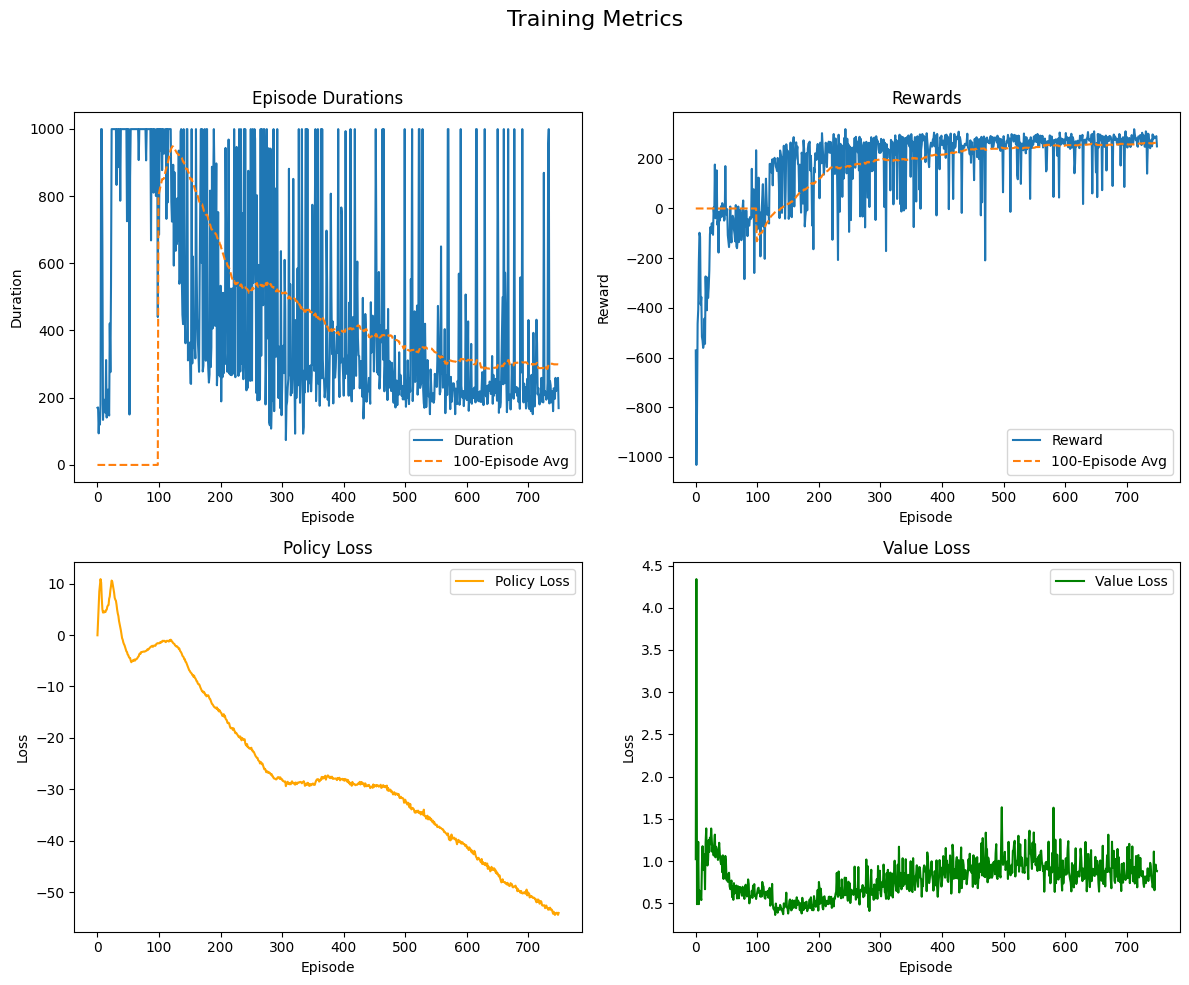

Training Progress: 100%|██████████| 750/750 [2:43:45<00:00, 13.10s/it, Episode=750, Steps Taken=346836, Total Reward=250, Episode Duration=169, Avg Policy Loss=-54.1, Avg Value Loss=0.846]

Training complete.


In [39]:
# Global metrics to track performance
episode_durations = []
episode_rewards = []
policy_losses = []
value_losses = []
steps_taken = 0
model_name = "sac_checkpoint_best"

# Timestamp for file saving
timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

output_dir = f"pre_trained_models/sac_continuous_lunar_lander_training_{timestamp}"

train_sac(
    env,
    actor,
    critic_1,
    critic_2,
    value_net,
    target_value_net,
    replay_buffer,
    sac_losses,
    actor_optimizer,
    critic_1_optimizer,
    critic_2_optimizer,
    value_optimizer,
    output_dir=output_dir,
    num_episodes=N_EPISODES_MAX,
    batch_size=64,
    gamma=0.99,
    tau=0.005,
    evaluate_interval=10,
    reward_window_threshold=230.0,
    reward_window_length=100,
    model_name=model_name,
)

Metrics figure saved to pre_trained_models/sac_continuous_lunar_lander_training_2024-12-24_17-59-32/soft_actor_critic_continuous_plot


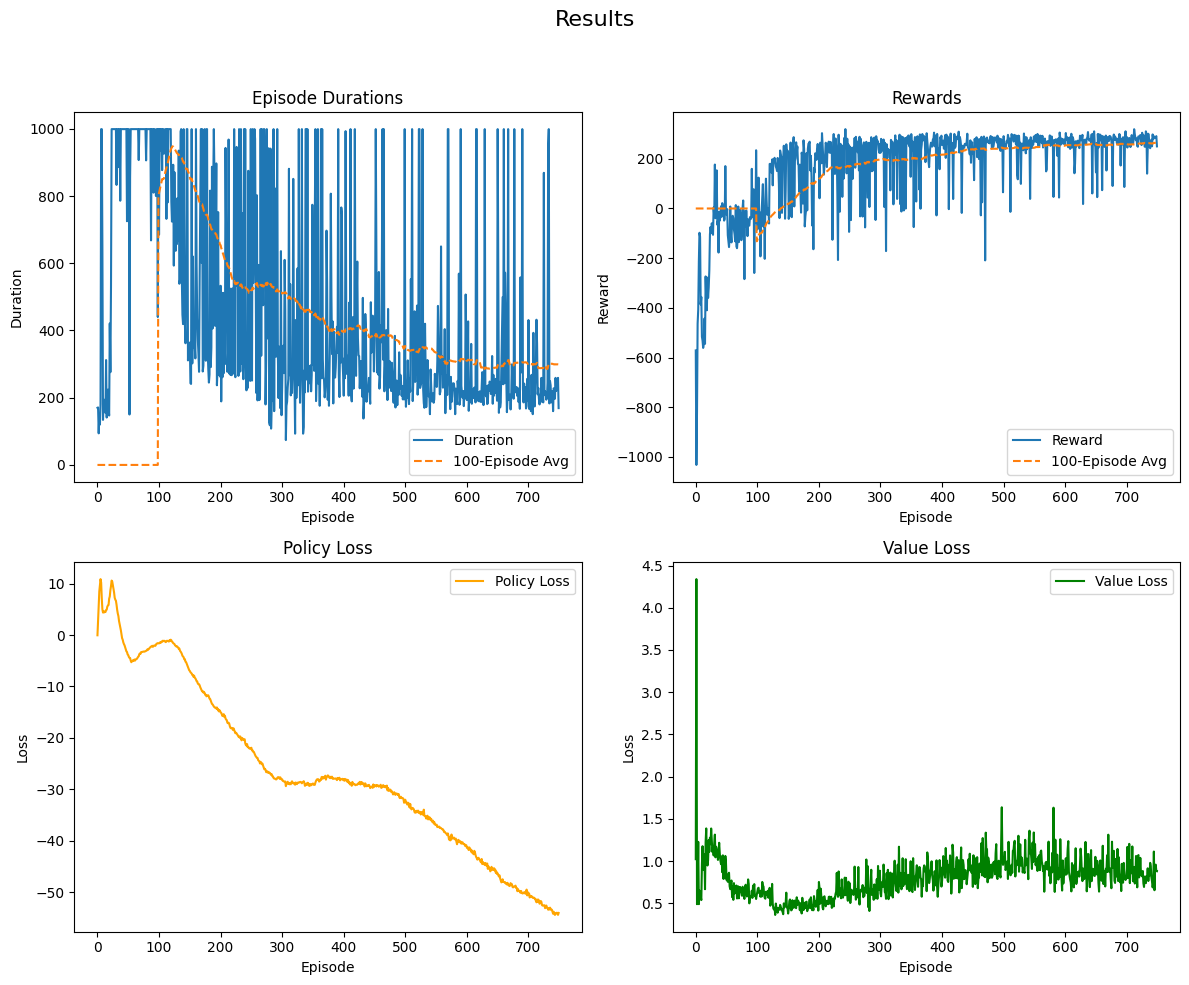

In [40]:
plot_metrics(
    episode_durations,
    episode_rewards,
    policy_losses,
    value_losses,
    show_result=True,
    save_path=f"{output_dir}/soft_actor_critic_continuous_plot",
)

## Load Saved Checkpoint and Save Policy

In [41]:
def save_policy_from_checkpoint(checkpoint_path: str, actor: Type[nn.Module], output_path: str = None) -> None:
    """
    Loads a checkpoint and saves only the actor (policy network) as a .pth file.

    Args:
        checkpoint_path (str): Path to the checkpoint file.
        actor (ActorNetwork): Actor network instance to load the weights into.
        output_path (str, optional): Path to save the policy network as a .pth file.
                                     Defaults to the same directory with a new filename.
    """
    if not os.path.isfile(checkpoint_path):
        raise FileNotFoundError(f"No checkpoint found at {checkpoint_path}")

    # Load the checkpoint
    checkpoint = torch.load(checkpoint_path, weights_only=True)

    # Load actor state dict
    actor.load_state_dict(checkpoint["actor_state_dict"])

    # Derive default output path if not provided
    if output_path is None:
        directory = os.path.dirname(checkpoint_path)
        output_path = os.path.join(directory, "policy_network.pth")

    # Save only the actor's weights
    torch.save(actor.state_dict(), output_path)
    print(f"Policy network saved to {output_path}")

In [42]:
state_dim = n_observations
action_dim = 2
hidden_dim = 256

actor_network = ActorNetwork(state_dim, action_dim, hidden_dim)
checkpoint_path = "output/sac_continuous_lunar_lander_training_2024-12-23_12-52-16/sac_checkpoint_best.pt"

output_dir = Path(output_dir)

# Save the model checkpoint
checkpoint_path = output_dir / f"{model_name}.pt"

save_policy_from_checkpoint(checkpoint_path, actor=actor_network)

Policy network saved to pre_trained_models/sac_continuous_lunar_lander_training_2024-12-24_17-59-32/policy_network.pth
